#Utility Functions

In [1]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 851 kB/s 


In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 2.1 MB/s 


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

In [17]:
import numpy as np
def getCols(df):
  all=list(df)
  df2=df.dropna()
  all.remove('Class')
  num_cols=[]
  for i in all:
    if type(df2[i])==np.float64 :
      num_cols.append(i)
  bin_cols=[]
  bin_cols = [col for col in df2 if np.isin(df2[col].unique(), [0, 1]).all()]
  cat_cols=[]
  for i in all:
    if i not in num_cols and i not in bin_cols and i!='Class':
      cat_cols.append(i)
  return [num_cols,cat_cols,bin_cols]

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
def metrics(cm):
        TN, FP, FN, TP = cm.ravel()
        precision =(TP)/(TP+FP)
        accuracy_model  =(TP+TN)/(TP+TN+FP+FN)
        recall_score  =(TP)/(TP+FN)
        specificity_value =(TN)/(TN + FP)
        
        False_positive_rate =(FP)/(FP+TN)
        False_negative_rate =(FN)/(FN+TP)
        f1_score =2*(( precision * recall_score)/( precision + recall_score))
        PPV=(TP)/(TP+FP)
        NPV=TN / (TN + FN) 
        print("PPV: ",PPV*100)
        print("NPV: ",NPV*100)
        print("Precision value of the model: ",precision*100)
        print("Accuracy of the model: ",accuracy_model*100)
        print("Recall of the model: ",recall_score*100)
        print("Specificity of the model: ",specificity_value*100)
        print("F1 Score of the model: ",f1_score*100)

# ICU DELIRIUM MIMIC DATASET

In [33]:
df=pd.read_csv('/content/delirium_mimic_icu_train_imputed.csv')
test=pd.read_csv('/content/delirium_mimic_icu_test_imputed.csv')


In [34]:
df.drop(['DISCHARGE_LOCATION','calprevflg'],axis=1,inplace=True)
test.drop(['DISCHARGE_LOCATION','calprevflg'],axis=1,inplace=True)

In [35]:
df.to_csv('delirium_icu_tr_mimic.csv')
test.to_csv('delirium_icu_ts_mimic.csv')

In [18]:
num_cols,cat_cols,bin_cols=getCols(df)

In [21]:
cat_cols=[ 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'GENDER']

In [22]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
df[cat_cols] = OrdinalEncoder().fit_transform(df[cat_cols])

In [23]:
test[cat_cols] = OrdinalEncoder().fit_transform(test[cat_cols])

In [ ]:
df[num_cols] = MinMaxScaler().fit_transform(df[num_cols])

In [ ]:
df.to_csv('delirium_mimic_icu_train_imputed_encoded.csv')

In [24]:
train_data=df.drop('Class',axis=1)
train_labels=df['Class']
test_data=test.drop('Class',axis=1)
test_labels=test['Class']

In [25]:
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,stratify=train_labels,random_state=11,test_size=0.1,shuffle=True)

## CatBoost

In [14]:
cat_features=[]
for i in range(0,len(list(train_data))):
  if list(train_data)[i] in cat_cols or list(train_data)[i] in bin_cols:
    cat_features.append(i)

from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(train_data, train_labels, cat_features, eval_set=(val_data,val_labels))


Learning rate set to 0.043781
0:	learn: 0.6588654	test: 0.6591630	best: 0.6591630 (0)	total: 136ms	remaining: 2m 15s
1:	learn: 0.6256826	test: 0.6257569	best: 0.6257569 (1)	total: 223ms	remaining: 1m 51s
2:	learn: 0.5961303	test: 0.5967838	best: 0.5967838 (2)	total: 293ms	remaining: 1m 37s
3:	learn: 0.5698718	test: 0.5720688	best: 0.5720688 (3)	total: 373ms	remaining: 1m 32s
4:	learn: 0.5431199	test: 0.5453968	best: 0.5453968 (4)	total: 443ms	remaining: 1m 28s
5:	learn: 0.5215913	test: 0.5247076	best: 0.5247076 (5)	total: 532ms	remaining: 1m 28s
6:	learn: 0.5017869	test: 0.5062536	best: 0.5062536 (6)	total: 597ms	remaining: 1m 24s
7:	learn: 0.4814240	test: 0.4883315	best: 0.4883315 (7)	total: 675ms	remaining: 1m 23s
8:	learn: 0.4636548	test: 0.4732136	best: 0.4732136 (8)	total: 716ms	remaining: 1m 18s
9:	learn: 0.4470890	test: 0.4563141	best: 0.4563141 (9)	total: 796ms	remaining: 1m 18s
10:	learn: 0.4340098	test: 0.4428852	best: 0.4428852 (10)	total: 865ms	remaining: 1m 17s
11:	learn: 

In [15]:
preds_class = model.predict(test_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(test_data)
prob=[] # raw data
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 0.9727366998444525
PPV:  88.52941176470588
NPV:  93.90420899854863
Precision value of the model:  88.52941176470588
Accuracy of the model:  92.12827988338192
Recall of the model:  87.75510204081633
Specificity of the model:  94.31486880466473
F1 Score of the model:  88.14055636896046


In [26]:
cat_features=[]
for i in range(0,len(list(train_data))):
  if list(train_data)[i] in cat_cols or list(train_data)[i] in bin_cols:
    cat_features.append(i)

from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(train_data, train_labels, eval_set=(val_data,val_labels))


Learning rate set to 0.043781
0:	learn: 0.6571948	test: 0.6579515	best: 0.6579515 (0)	total: 30.3ms	remaining: 30.3s
1:	learn: 0.6245428	test: 0.6255229	best: 0.6255229 (1)	total: 52.8ms	remaining: 26.3s
2:	learn: 0.5955441	test: 0.5990538	best: 0.5990538 (2)	total: 75.8ms	remaining: 25.2s
3:	learn: 0.5681613	test: 0.5724961	best: 0.5724961 (3)	total: 98.4ms	remaining: 24.5s
4:	learn: 0.5442211	test: 0.5487011	best: 0.5487011 (4)	total: 121ms	remaining: 24.1s
5:	learn: 0.5219276	test: 0.5279549	best: 0.5279549 (5)	total: 144ms	remaining: 23.9s
6:	learn: 0.4994936	test: 0.5067307	best: 0.5067307 (6)	total: 169ms	remaining: 24s
7:	learn: 0.4817175	test: 0.4886496	best: 0.4886496 (7)	total: 193ms	remaining: 23.9s
8:	learn: 0.4654795	test: 0.4732855	best: 0.4732855 (8)	total: 222ms	remaining: 24.4s
9:	learn: 0.4517760	test: 0.4605192	best: 0.4605192 (9)	total: 244ms	remaining: 24.2s
10:	learn: 0.4391543	test: 0.4484093	best: 0.4484093 (10)	total: 267ms	remaining: 24s
11:	learn: 0.4254423	t

In [27]:
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
prob=[] # encoded data
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 0.9710707273329989
PPV:  88.82175226586104
NPV:  92.97994269340974
Precision value of the model:  88.82175226586104
Accuracy of the model:  91.64237123420797
Recall of the model:  85.71428571428571
Specificity of the model:  94.60641399416909
F1 Score of the model:  87.24035608308606


In [ ]:
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)

75% missingness threshold

In [ ]:
prob=[] # raw data
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 0.970964479086095
PPV:  87.86982248520711
NPV:  93.34298118668596
Precision value of the model:  87.86982248520711
Accuracy of the model:  91.54518950437318
Recall of the model:  86.58892128279884
Specificity of the model:  94.02332361516035
F1 Score of the model:  87.22466960352423


In [ ]:
prob=[] #with ordinal encoding only
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 0.9694090047514216
PPV:  87.72455089820359
NPV:  92.80575539568345
Precision value of the model:  87.72455089820359
Accuracy of the model:  91.15646258503402
Recall of the model:  85.42274052478133
Specificity of the model:  94.02332361516035
F1 Score of the model:  86.55834564254062


In [ ]:
prob=[] #with scaling of numerical variables
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 0.5857678348307254
PPV:  42.857142857142854
NPV:  68.52497096399536
Precision value of the model:  42.857142857142854
Accuracy of the model:  64.33430515063168
Recall of the model:  20.99125364431487
Specificity of the model:  86.0058309037901
F1 Score of the model:  28.180039138943247


35 missingness threshold

In [ ]:
prob=[] #35 missing values percentage threshold - raw data
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 0.9329212317996752
PPV:  87.41935483870968
NPV:  89.98609179415855
Precision value of the model:  87.41935483870968
Accuracy of the model:  89.21282798833819
Recall of the model:  79.00874635568513
Specificity of the model:  94.31486880466473
F1 Score of the model:  83.00153139356816


## XGBoost

In [19]:
df=pd.read_csv('/content/delirium_mimic_icu_train_imputed_encoded.csv')
X=df.drop('Class',axis=1)
y=df['Class']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=123)

In [23]:
df_test=pd.read_csv('/content/delirium_mimic_icu_test_imputed_encoded.csv')
X_test=df_test.drop('Class',axis=1)
y_test=df_test['Class']

In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [30]:
xgb.fit(train_data,train_labels)

preds = xgb.predict(test_data)

In [31]:
preds_class = xgb.predict(test_data)
preds_proba = xgb.predict_proba(test_data)
prob=[] 
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 0.964547084973098
PPV:  87.79761904761905
NPV:  93.07359307359307
Precision value of the model:  87.79761904761905
Accuracy of the model:  91.3508260447036
Recall of the model:  86.0058309037901
Specificity of the model:  94.02332361516035
F1 Score of the model:  86.89248895434464


In [14]:
# 75 scaled & encoded
preds_class = xgb.predict(X_test)
preds_proba = xgb.predict_proba(X_test)
prob=[] 
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(y_test,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(y_test,preds_class)
metrics(cm)

ROC_AUC: 0.6167646983824767
PPV:  38.283378746594
NPV:  78.98305084745762
Precision value of the model:  38.283378746594
Accuracy of the model:  49.9514091350826
Recall of the model:  81.92419825072886
Specificity of the model:  33.965014577259474
F1 Score of the model:  52.1819870009285


#NON-ICU DELIRIUM AUBMC DATASET

In [30]:
df=pd.read_csv('/content/aubmc_train_downsampled_enc.csv')
test=pd.read_csv('/content/aubmc_test_enc.csv')
train_data=df.drop('Class',axis=1)
train_labels=df['Class']
test_data=test.drop('Class',axis=1)
test_labels=test['Class']

In [12]:
classest=test['Class']
classes=df['Class']

class_tr=[]
for i in classes:
  if i=='possible' or i=='confirmed':
    class_tr.append(1)
  else:
    class_tr.append(0)

class_ts=[]
for i in classest:
  if i=='possible' or i=='confirmed':
    class_ts.append(1)
  else:
    class_ts.append(0)

test['Class']=class_ts
df['Class']=class_tr

In [13]:
df.to_csv('aubmc_train_56thresh.csv')
test.to_csv('aubmc_test_56thresh.csv')

In [31]:
train_data=df.drop('Class',axis=1)
train_labels=df['Class']
test_data=test.drop('Class',axis=1)
test_labels=test['Class']

In [7]:
import category_encoders as ce

In [7]:
df.columns #75% threshold

Index(['Unnamed: 0', 'BP_SYSTOLIC', 'BP_DIASTOLIC', 'TEMPERATURE', 'PULSE',
       'WEIGHT', 'HEIGHT', 'RESPIRATIONS', 'BMI', 'BSA', '325', '2401', '2405',
       '8428', '9637', '9639', '10608', '112703', '169448', '169449', '169861',
       '175233', '182878', '186252', '192673', '400051', '400562', '400580',
       '40802017', 'TOBACCO_TYPE', 'CIGARETTES_YN', 'PIPES_YN', 'CIGARS_YN',
       'ALCOHOL_USE', 'ADD_LINE_1', 'NATIONALITY', 'SEX_C',
       'Rest_due_to_violence', 'Use_of_rest', 'agitation', 'parkinson',
       'alzeihmer', 'depression', 'ocd', 'anxiety', 'bipolar', 'abuse',
       'antipsychotics', 'lithium', 'cancer', 'LOS', 'Age', 'Class'],
      dtype='object')

In [17]:
num_cols,cat_cols,bin_cols=getCols(df)

In [50]:
cat_cols=[
 '325',
 '2401',
 '2405',
 '9637',
 '10608',
 '169448',
 '169449',
 '175233',
 'ADD_LINE_1',
 '182878',
 '40802017',
 'TOBACCO_TYPE',
 'CIGARETTES_YN',
 'PIPES_YN',
 'CIGARS_YN',
 'ALCOHOL_USE',
 'NATIONALITY',
 'SEX_C']

In [32]:
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,stratify=train_labels,random_state=11,test_size=0.1,shuffle=True)

In [33]:
cat_cols=['ADD_LINE_1',
          '325',
          '2401',
          '2405',
          '8428',
          '9637',
          '10608',
          '169448',
          '169449',
          '175233',
          '182878',
          '40802017',
          'NATIONALITY',
          'SEX_C']

In [34]:
train_data

,BP_SYSTOLIC,BP_DIASTOLIC,TEMPERATURE,PULSE,WEIGHT,HEIGHT,RESPIRATIONS,BMI,BSA,325,...,depression,ocd,anxiety,bipolar,abuse,antipsychotics,lithium,cancer,LOS,Age
965,132.0,87.0,97.7,81.0,86.000575,1.569999,16.0,34.890000,1.940000,0,...,0,0,0,0,0,0,0,0,1,49.4
727,130.0,60.0,98.8,62.0,98.000563,1.589989,14.0,38.760000,2.080000,0,...,0,0,0,0,0,0,0,0,7,67.4
839,121.0,85.0,97.9,95.0,72.000495,1.759991,18.0,23.240000,1.880000,0,...,0,0,0,0,0,0,0,0,6,53.5
27,57.0,42.0,97.2,63.0,69.000498,1.499997,0.0,30.670000,1.700000,0,...,0,0,0,0,0,0,0,0,35,87.5
892,144.0,89.0,97.9,65.0,84.000483,1.750009,20.0,27.430000,2.020000,1,...,0,0,0,0,0,0,0,0,5,86.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,125.0,77.0,98.0,84.0,67.500500,1.499997,16.0,30.000000,1.680000,0,...,0,0,0,0,0,0,0,0,48,61.0
548,177.0,94.0,97.7,72.0,77.600795,1.658397,18.0,27.048705,1.873885,0,...,0,0,0,0,0,0,0,0,2,54.4
503,150.0,92.0,98.1,74.0,56.000322,1.559992,16.0,23.010000,1.560000,0,...,0,0,0,0,0,0,0,0,11,92.5
850,141.0,66.0,97.3,62.0,77.500395,1.729994,16.0,25.890000,1.930000,0,...,0,0,0,0,0,0,0,0,9,89.1


In [52]:
cat_features=[]
for i in range(0,len(list(train_data))):
  if list(train_data)[i] in cat_cols: #or list(train_data)[i] in bin_cols:
    cat_features.append(i)

from catboost import CatBoostClassifier
model = CatBoostClassifier()
# Fit model
model.fit(train_data, train_labels,cat_features=cat_features,eval_set=(val_data,val_labels))


Learning rate set to 0.02665
0:	learn: 0.6815150	test: 0.6826246	best: 0.6826246 (0)	total: 6.23ms	remaining: 6.22s
1:	learn: 0.6678456	test: 0.6723374	best: 0.6723374 (1)	total: 16.8ms	remaining: 8.36s
2:	learn: 0.6584462	test: 0.6621748	best: 0.6621748 (2)	total: 21.2ms	remaining: 7.04s
3:	learn: 0.6463342	test: 0.6516301	best: 0.6516301 (3)	total: 32.8ms	remaining: 8.16s
4:	learn: 0.6382411	test: 0.6451419	best: 0.6451419 (4)	total: 37.4ms	remaining: 7.44s
5:	learn: 0.6295098	test: 0.6369949	best: 0.6369949 (5)	total: 48.6ms	remaining: 8.05s
6:	learn: 0.6229097	test: 0.6308916	best: 0.6308916 (6)	total: 60.4ms	remaining: 8.56s
7:	learn: 0.6132996	test: 0.6204888	best: 0.6204888 (7)	total: 71.6ms	remaining: 8.88s
8:	learn: 0.6109502	test: 0.6186717	best: 0.6186717 (8)	total: 74.9ms	remaining: 8.25s
9:	learn: 0.5998464	test: 0.6078304	best: 0.6078304 (9)	total: 86.1ms	remaining: 8.52s
10:	learn: 0.5933166	test: 0.6022244	best: 0.6022244 (10)	total: 97ms	remaining: 8.72s
11:	learn: 0.5

In [16]:
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
prob=[] #AUBMC --> ENCODED 
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(100*roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 85.86580412216037
PPV:  47.61904761904761
NPV:  94.11764705882352
Precision value of the model:  47.61904761904761
Accuracy of the model:  85.37313432835822
Recall of the model:  65.21739130434783
Specificity of the model:  88.58131487889274
F1 Score of the model:  55.04587155963303


In [28]:
cat_features=[]
for i in range(0,len(list(train_data))):
  if list(train_data)[i] in cat_cols:
    cat_features.append(i)

from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(train_data, train_labels, cat_features=cat_features,eval_set=(val_data,val_labels))


Learning rate set to 0.02665
0:	learn: 0.6815150	test: 0.6826246	best: 0.6826246 (0)	total: 6.14ms	remaining: 6.13s
1:	learn: 0.6678456	test: 0.6723374	best: 0.6723374 (1)	total: 18.2ms	remaining: 9.08s
2:	learn: 0.6584462	test: 0.6621748	best: 0.6621748 (2)	total: 23.1ms	remaining: 7.67s
3:	learn: 0.6463342	test: 0.6516301	best: 0.6516301 (3)	total: 39.1ms	remaining: 9.74s
4:	learn: 0.6382411	test: 0.6451419	best: 0.6451419 (4)	total: 43.9ms	remaining: 8.73s
5:	learn: 0.6295098	test: 0.6369949	best: 0.6369949 (5)	total: 57.1ms	remaining: 9.46s
6:	learn: 0.6229097	test: 0.6308916	best: 0.6308916 (6)	total: 70.7ms	remaining: 10s
7:	learn: 0.6132996	test: 0.6204888	best: 0.6204888 (7)	total: 98ms	remaining: 12.2s
8:	learn: 0.6109502	test: 0.6186717	best: 0.6186717 (8)	total: 105ms	remaining: 11.6s
9:	learn: 0.5998464	test: 0.6078304	best: 0.6078304 (9)	total: 126ms	remaining: 12.5s
10:	learn: 0.5933166	test: 0.6022244	best: 0.6022244 (10)	total: 151ms	remaining: 13.6s
11:	learn: 0.587699

In [53]:
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
prob=[] #AUBMC --> RAW 
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(100*roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 88.54370392658343
PPV:  50.0
NPV:  95.16728624535315
Precision value of the model:  50.0
Accuracy of the model:  86.26865671641791
Recall of the model:  71.73913043478261
Specificity of the model:  88.58131487889274
F1 Score of the model:  58.928571428571416


In [18]:
from xgboost import XGBClassifier #AUBMC -->-------- ENCODED
xgb = XGBClassifier()
xgb.fit(train_data,train_labels)

preds = xgb.predict(test_data)

preds_class = xgb.predict(test_data)
preds_proba = xgb.predict_proba(test_data)
prob=[]
for i in preds_proba:
  prob.append(i[1])

from sklearn.metrics import roc_auc_score
print('ROC_AUC: '+str(roc_auc_score(test_labels,prob)))
from sklearn.metrics import log_loss, roc_curve,confusion_matrix, auc
cm=confusion_matrix(test_labels,preds_class)
metrics(cm)

ROC_AUC: 0.8340604784113134
PPV:  39.02439024390244
NPV:  94.46640316205533
Precision value of the model:  39.02439024390244
Accuracy of the model:  80.8955223880597
Recall of the model:  69.56521739130434
Specificity of the model:  82.69896193771626
F1 Score of the model:  50.000000000000014


Text(0.5, 1.0, 'Feature Importance')

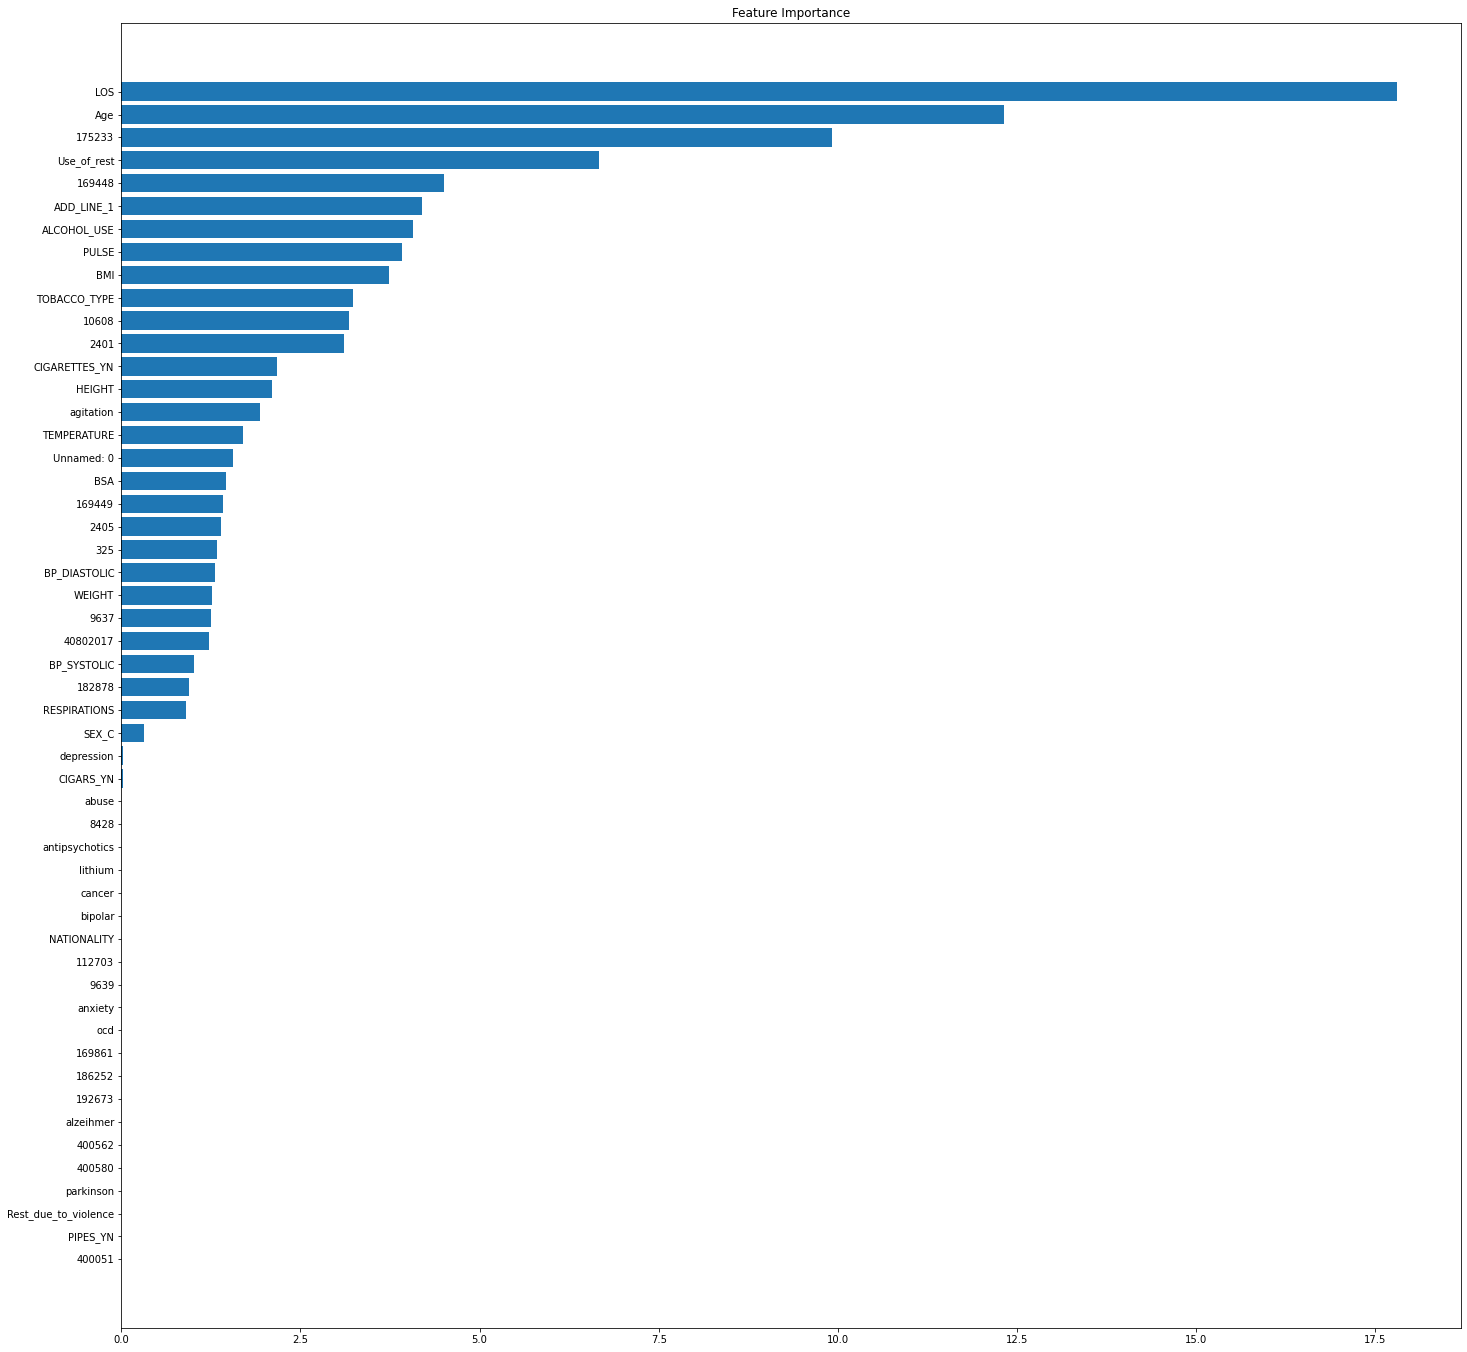

In [57]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(val_data.columns)[sorted_idx])
plt.title('Feature Importance')


In [58]:
cols_to_drop=[]
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
for i in sorted_idx:
  print(np.array(val_data.columns)[i])
  print(feature_importance[i])
  if feature_importance[i]<0.1:
    cols_to_drop.append(np.array(val_data.columns)[i])

400051
0.0
PIPES_YN
0.0
Rest_due_to_violence
0.0
parkinson
0.0
400580
0.0
400562
0.0
alzeihmer
0.0
192673
0.0
186252
0.0
169861
0.0
ocd
0.0
anxiety
0.0
9639
0.0
112703
0.0
NATIONALITY
0.0
bipolar
0.0
cancer
0.0
lithium
0.0
antipsychotics
0.0
8428
0.0
abuse
0.0
CIGARS_YN
0.02335718641654886
depression
0.024747391529364653
SEX_C
0.3108133483414867
RESPIRATIONS
0.8986203192485079
182878
0.9395693880407824
BP_SYSTOLIC
1.0111412422250834
40802017
1.2172367047086745
9637
1.2561345439279221
WEIGHT
1.2689391896570523
BP_DIASTOLIC
1.3067163052951938
325
1.340763739848512
2405
1.3891649877060712
169449
1.4169922538713884
BSA
1.4647798724107413
Unnamed: 0
1.5532046661315642
TEMPERATURE
1.7048278544695532
agitation
1.9415530060195056
HEIGHT
2.10746449740141
CIGARETTES_YN
2.172581537679838
2401
3.1136551411709115
10608
3.1837734738621752
TOBACCO_TYPE
3.234787495764277
BMI
3.7326450635877926
PULSE
3.911379340107415
ALCOHOL_USE
4.0728817877950085
ADD_LINE_1
4.200048479040513
169448
4.499016296190936


In [63]:
df.drop(cols_to_drop,inplace=True,axis=1)
test.drop(cols_to_drop,inplace=True,axis=1)

In [64]:
df.to_csv('aubmc_train_downsampled_feat_enc.csv')
test.to_csv('aubmc_test_feat_enc.csv')